In [1]:
import jax 
import jax.numpy as jnp
import equinox as eqx
import optax   
import matplotlib.pyplot as plt
from typing import List

In [2]:
# nr of samples 
N_SAMPLES = 200

# one 1-node input, three 10-node hidden layers, and one 1-node output.
LAYERS = [1, 10, 10, 10, 1]

# set learning rate 
LEARNING_RATE = 0.1 

# set nr epochs 
N_EPOCHS = 30_000

In [3]:
# Data generation. Want to simulate a sinus wave with random feature and random y. 

# setting up random key so we can reproduce results
key = jax.random.key(42)
   

In [4]:
# want keys for features and target. 
key, xkey, ykey = jax.random.split(key, 3) 

(200, 1) (200, 1)


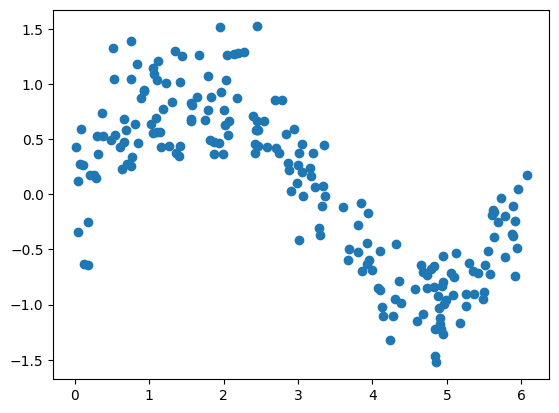

In [5]:
  # pick random values between 0-2pi. x-axis is out feature

# scale of the noise of y 
normal_scale = 0.3 

# pick N_SAMPLES uniform distributed values in [0,2pi). shape = (samples, features)
x_samples = jax.random.uniform(xkey, shape=(N_SAMPLES, 1), minval=0.0, maxval=2.0 *jnp.pi)

# evalute sin at x_samples with added scaled normal distributed noise. 
y_samples = jnp.sin(x_samples) + jax.random.normal(ykey, shape=(N_SAMPLES, 1)) * normal_scale

print(x_samples.shape, y_samples.shape)
plt.scatter(x_samples, y_samples)

In [6]:
print(LAYERS)
print(LAYERS[:-1])
print(LAYERS[1:])
print(list(zip(LAYERS[:-1], LAYERS[1:])))

[1, 10, 10, 10, 1]
[1, 10, 10, 10]
[10, 10, 10, 1]
[(1, 10), (10, 10), (10, 10), (10, 1)]


In [7]:
# defining a simple feed-forward multi-layered perceptron. 

class simpleMLP(eqx.Module):
    layers: List[eqx.nn.Linear]

    def __init__(self, list_layer_size, key):
        self.layers = []

        # layer transitions 
        for (in_size,out_size) in zip(list_layer_size[:-1], list_layer_size[1:]):
            key, subkey = jax.random.split(key) # default split into two keys
            self.layers.append(
                eqx.nn.Linear(in_size,out_size, use_bias=True, key = subkey)
            )
           
    def __call__(self,x):
        tmp = x
        for layer in self.layers[:-1]:
            tmp = jax.nn.sigmoid(layer(tmp)) 
        tmp = self.layers[-1](tmp)

        return tmp
        
 
           
             
             



In [8]:
model = simpleMLP(LAYERS, key=key)

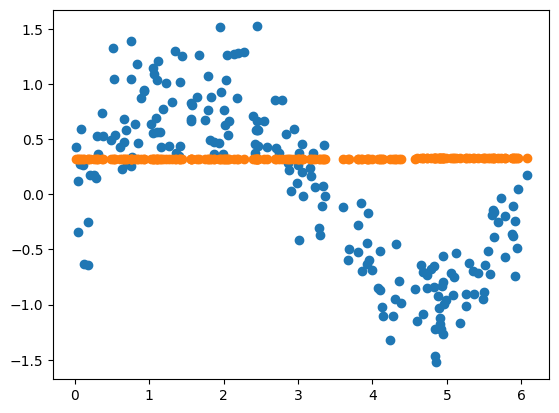

In [47]:
# init prediction
plt.scatter(x_samples, y_samples) # reference  
plt.scatter(x_samples, jax.vmap(model)(x_samples))

# jax.vmap vectorize the model. We can apply the model-function to each x_sample in a vectorized manner.
# x_samples = [e_1, e_2, ..., e_n]
# model_vec(x) = jax.vmap(model) = [model(x), model(x), ..., model(x)], where the lenght = len(x_samples)
# model_vec(x_samples) = [model(e_1), model(e_2), ..., model(e_n)] 

In [15]:
type(x_samples)

jaxlib.xla_extension.ArrayImpl

In [16]:
# defining loss function. A loss function a core component of learning. Without it we don't know how well we did given the known values. 
# It is the difference between what you know and the true known value. 

def model_to_loss(model: simpleMLP, x: jax.Array, y: jax.Array) -> jax.Array:
    prediction = jax.vmap(model)(x) 
    difference = prediction - y
    loss = jnp.mean(difference**2)  
    return loss

In [21]:
# now we need to construct the learning process i.e. the optimization process.
# we want the model to learn from the loss and update its weight accordingly. 
# The loss function depends on three things. The model, the features, and the target variable y. 
# But for now let's focus on the model. The loss depends on the parameters of the model. The learning rate, architecture, etc. 
# We want to use a gradient based approach. The holy-grail is to find the global minimum of the loss function. Practially it is impossible due 
# to the fact that the optimization problem is not convex. 
# The best we can do is to find the local-minimum of the loss-function. So we want to use the gradient and walk in the opposite direction of the gradient. The 
#gradient points to the maximum so we walk in the opposite direction to the minimum.   

model_to_loss__and_grad = eqx.filter_value_and_grad(fun = model_to_loss) # differentiate the pure loss function with respect to the first parameter i.e. the model. 


In [27]:
model_to_loss__and_grad(model, x_samples, y_samples)

(Array(0.62487847, dtype=float32),
 simpleMLP(
   layers=[
     Linear(
       weight=f32[10,1],
       bias=f32[10],
       in_features=1,
       out_features=10,
       use_bias=True
     ),
     Linear(
       weight=f32[10,10],
       bias=f32[10],
       in_features=10,
       out_features=10,
       use_bias=True
     ),
     Linear(
       weight=f32[10,10],
       bias=f32[10],
       in_features=10,
       out_features=10,
       use_bias=True
     ),
     Linear(
       weight=f32[1,10],
       bias=f32[1],
       in_features=10,
       out_features=1,
       use_bias=True
     )
   ]
 ))

In [35]:
# now we want to create a update rule given the gradient. How should we update the weights? Many different ways to do it. 
opt = optax.sgd(learning_rate=LEARNING_RATE)

# opt weight state 
opt_state = opt.init(eqx.filter(model, eqx.is_array))
 